In [2]:
# pip install ase dscribe matplotlib seaborn scikit-learn tensorflow
# pip install --upgrade pip
# pip install tensorflow

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dscribe.descriptors import SOAP
from ase.io import read, write
import seaborn as sns
%matplotlib inline

In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [5]:
path_to_POSCAR_MBT_unlabelled = 'added_5000_unlabelled_data/'
path_to_POSCAR_MBT_labelled = 'DFT_CONTCARs_MBT/'

In [6]:
def read_POSCAR(file_path):

    poscar_info_list = []
    atomic_species_list = []
    unique_atomic_species_list = set()
    
    for file in os.listdir(file_path):
        if file.endswith('.vasp'):
            poscar_path = os.path.join(file_path, file)
            poscar = read(poscar_path, format = 'vasp')
            poscar_info_list.append(poscar)
            atomic_species_list.append(poscar.get_chemical_symbols())
            for atoms in atomic_species_list:
                unique_atomic_species_list.update(poscar.get_chemical_symbols())
    return poscar_info_list, atomic_species_list, list(unique_atomic_species_list)

In [7]:
poscar_info_list_labelled, atomic_species_list_labelled, unique_atomic_species_list_labelled = read_POSCAR(path_to_POSCAR_MBT_labelled)
poscar_info_list_unlabelled, atomic_species_list_unlabelled, unique_atomic_species_list_unlabelled = read_POSCAR(path_to_POSCAR_MBT_unlabelled)

unique_atomic_species_list = list(set(unique_atomic_species_list_labelled + unique_atomic_species_list_unlabelled))
poscar_info_list = poscar_info_list_labelled + poscar_info_list_unlabelled

In [8]:
def get_SOAP_descriptor(poscar_info_list, r_cut, n_max, l_max):
    
    soap = SOAP(species = unique_atomic_species_list,
               r_cut = r_cut,
               n_max = n_max,
               l_max = l_max,
                sigma = 0.5,    # default: 1.0
                rbf = 'gto',    # deafult: 'gto'
                average='inner',  # default: 'off'
                periodic=True,  # default: False
                sparse=False)    # default: False
    soap_desc = []
    for struct in poscar_info_list:
        soap_struct = soap.create(struct)
        soap_desc.append(soap_struct)
    return np.vstack(soap_desc)

In [9]:
soap_desc = get_SOAP_descriptor(poscar_info_list, 9.0, 6, 5)
soap_desc_labelled = get_SOAP_descriptor(poscar_info_list_labelled, 9.0, 6, 5)

In [10]:
print(soap_desc.shape)
print(soap_desc_labelled.shape)

(5240, 79218)
(240, 79218)


In [11]:
def plot_PCA_variance(soap_desc, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(soap_desc)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('SOAP Descriptors of MBT monolayer')
    plt.grid(True)
    plt.show()

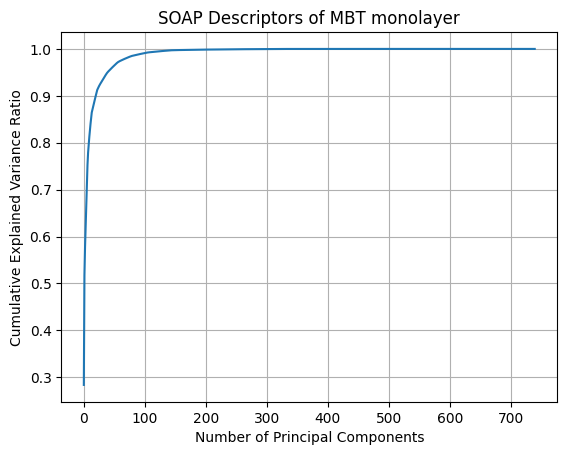

In [12]:
plot_PCA_variance(soap_desc,740)

In [13]:
def perform_pca(soap_desc, optimal_components):
    pca = PCA(n_components=optimal_components)
    soap_pca = pca.fit_transform(soap_desc)
    return soap_pca

In [14]:
optimized_pca = perform_pca(soap_desc,200)
optimized_pca_labelled = perform_pca(soap_desc_labelled,200)

In [15]:
print(optimized_pca.shape)
print(optimized_pca_labelled.shape)

(5240, 200)
(240, 200)


In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(optimized_pca)
X_labelled = scaler.fit_transform(optimized_pca_labelled)

latent_size = 64
input_dim = X.shape[1]

In [17]:
encoder_input = keras.Input(shape=(input_dim,))
encoder_hid_layer_1 = keras.layers.Dense(128, activation = 'selu')(encoder_input)
encoder_hid_layer_2 = keras.layers.Dense(96, activation = 'selu')(encoder_hid_layer_1)
encoder_output = keras.layers.Dense(64, activation = 'selu')(encoder_hid_layer_2)

In [18]:
decoder_hid_layer_1 = keras.layers.Dense(96, activation = 'selu')(encoder_output)
decoder_hid_layer_2 = keras.layers.Dense(128, activation = 'selu')(decoder_hid_layer_1)
decoder_output = keras.layers.Dense(input_dim, activation = 'linear')(decoder_hid_layer_2)

In [19]:
autoencoder = keras.models.Model(inputs = encoder_input, outputs = decoder_output)
autoencoder.compile(optimizer='adam', loss = 'mae',)

In [20]:
hist_autoencoder = autoencoder.fit(X, X, epochs = 500, batch_size = 32, validation_split = 0.2)

Epoch 1/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7233 - val_loss: 0.5529
Epoch 2/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5398 - val_loss: 0.5194
Epoch 3/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4939 - val_loss: 0.4940
Epoch 4/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4579 - val_loss: 0.4798
Epoch 5/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4404 - val_loss: 0.4681
Epoch 6/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4205 - val_loss: 0.4569
Epoch 7/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4150 - val_loss: 0.4527
Epoch 8/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3976 - val_loss: 0.4470
Epoch 9/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3937 - val_loss: 0.4424
Epoch 10/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3869 - val_loss: 0.4395
Epoch 11/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3765 - val_loss: 0.4368
Epoch 12/500
131/131 ━━━━━━━━━━━━━━━━━━━━

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3226 - val_loss: 0.4067
Epoch 69/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3230 - val_loss: 0.4076
Epoch 70/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3200 - val_loss: 0.4076
Epoch 71/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3233 - val_loss: 0.4067
Epoch 72/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3200 - val_loss: 0.4070
Epoch 73/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3189 - val_loss: 0.4061
Epoch 74/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3189 - val_loss: 0.4060
Epoch 75/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3199 - val_loss: 0.4058
Epoch 76/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3201 - val_loss: 0.4070
Epoch 77/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3197 - val_loss: 0.4078
Epoch 78/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3175 - val_loss: 0.4057
Epoch 79/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 

Epoch 135/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2884 - val_loss: 0.3992
Epoch 136/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2926 - val_loss: 0.3993
Epoch 137/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2890 - val_loss: 0.3982
Epoch 138/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2866 - val_loss: 0.3986
Epoch 139/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2892 - val_loss: 0.3976
Epoch 140/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2867 - val_loss: 0.3996
Epoch 141/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2883 - val_loss: 0.3994
Epoch 142/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2885 - val_loss: 0.3994
Epoch 143/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2890 - val_loss: 0.3984
Epoch 144/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2899 - val_loss: 0.3996
Epoch 145/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2940 - val_loss: 0.3991
Epoch 146/500
131/131

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2724 - val_loss: 0.3960
Epoch 202/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2736 - val_loss: 0.3968
Epoch 203/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2717 - val_loss: 0.3977
Epoch 204/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2781 - val_loss: 0.3961
Epoch 205/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2741 - val_loss: 0.3962
Epoch 206/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2728 - val_loss: 0.3966
Epoch 207/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2733 - val_loss: 0.3971
Epoch 208/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2747 - val_loss: 0.3966
Epoch 209/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2744 - val_loss: 0.3958
Epoch 210/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2721 - val_loss: 0.3974
Epoch 211/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2722 - val_loss: 0.3954
Epoch 212/500
131/131 ━━━━━━━━━━━━━

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2608 - val_loss: 0.3971
Epoch 268/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2630 - val_loss: 0.3945
Epoch 269/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2631 - val_loss: 0.3935
Epoch 270/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2625 - val_loss: 0.3949
Epoch 271/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2644 - val_loss: 0.3951
Epoch 272/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2590 - val_loss: 0.3967
Epoch 273/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2617 - val_loss: 0.3958
Epoch 274/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2599 - val_loss: 0.3950
Epoch 275/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2653 - val_loss: 0.3974
Epoch 276/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2613 - val_loss: 0.3942
Epoch 277/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2601 - val_loss: 0.3942
Epoch 278/500
131/131 ━━━━━━━━━━━━━

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2522 - val_loss: 0.3964
Epoch 334/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2544 - val_loss: 0.3947
Epoch 335/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2547 - val_loss: 0.3954
Epoch 336/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2475 - val_loss: 0.3964
Epoch 337/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2482 - val_loss: 0.3967
Epoch 338/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2535 - val_loss: 0.3932
Epoch 339/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2522 - val_loss: 0.3950
Epoch 340/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2518 - val_loss: 0.3945
Epoch 341/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2472 - val_loss: 0.3941
Epoch 342/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2496 - val_loss: 0.3949
Epoch 343/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2520 - val_loss: 0.3933
Epoch 344/500
131/131 ━━━━━━━━━━━━━

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2463 - val_loss: 0.3897
Epoch 400/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2433 - val_loss: 0.3901
Epoch 401/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2479 - val_loss: 0.3915
Epoch 402/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2447 - val_loss: 0.3911
Epoch 403/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2450 - val_loss: 0.3921
Epoch 404/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2461 - val_loss: 0.3900
Epoch 405/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2444 - val_loss: 0.3909
Epoch 406/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2457 - val_loss: 0.3913
Epoch 407/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2465 - val_loss: 0.3892
Epoch 408/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2467 - val_loss: 0.3913
Epoch 409/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2477 - val_loss: 0.3892
Epoch 410/500
131/131 ━━━━━━━━━━━━━

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2402 - val_loss: 0.3898
Epoch 466/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2432 - val_loss: 0.3874
Epoch 467/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2419 - val_loss: 0.3857
Epoch 468/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2465 - val_loss: 0.3871
Epoch 469/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2400 - val_loss: 0.3881
Epoch 470/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2422 - val_loss: 0.3867
Epoch 471/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2409 - val_loss: 0.3885
Epoch 472/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2438 - val_loss: 0.3873
Epoch 473/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2421 - val_loss: 0.3869
Epoch 474/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2380 - val_loss: 0.3860
Epoch 475/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2422 - val_loss: 0.3887
Epoch 476/500
131/131 ━━━━━━━━━━━━━

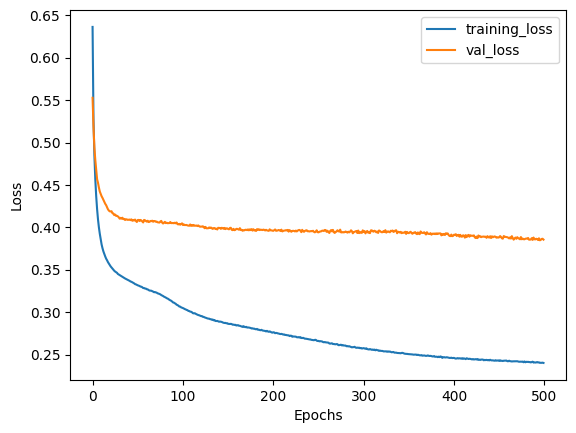

In [21]:
plt.plot(hist_autoencoder.history['loss'], label='training_loss')
plt.plot(hist_autoencoder.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [22]:
reconstructed_X = autoencoder.predict(X)
reconstructed_X_labelled = autoencoder.predict(X_labelled)

encoder = keras.models.Model(inputs = encoder_input, outputs = encoder_output)

compressed_X = encoder.predict(X)
compressed_X_labelled = encoder.predict(X_labelled)

print(compressed_X.shape)
print(compressed_X_labelled.shape)

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
(5240, 64)
(240, 64)


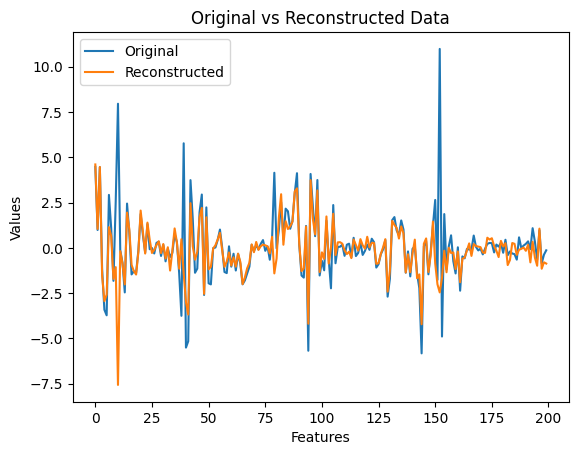

In [23]:
sample_idx = X[0]
plt.plot(X[0], label='Original')
plt.plot(reconstructed_X[0], label='Reconstructed')
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Original vs Reconstructed Data')
plt.legend()
plt.show()

In [24]:
## FFNN

In [25]:
monolayer_MBT_DFT_data = pd.read_csv('id_props_240_labelled_data_MBT.csv')

In [26]:
y = monolayer_MBT_DFT_data[['Ef_per_cell','Mu_per_cell','Eg']]

In [27]:
ffnn_MBT = keras.models.Sequential([
    keras.layers.Dense(32, activation = 'selu', input_dim = latent_size),
    keras.layers.Dense(16, activation = 'selu'),
    keras.layers.Dense(8, activation = 'selu'),
    keras.layers.Dense(3, activation = 'linear')
])

C:\Users\Romakanta\Desktop\vENVs\vSOAP\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(compressed_X_labelled, y, test_size = 0.2, random_state = 1)

In [29]:
ffnn_MBT.compile(optimizer = 'adam', loss = 'mae')
hist_ffnn_MBT = ffnn_MBT.fit(X_train, y_train, epochs = 500, batch_size = 32, validation_split = 0.2)

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.6873 - val_loss: 1.4153
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3907 - val_loss: 1.2725
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2460 - val_loss: 1.2365
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1841 - val_loss: 1.2028
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0244 - val_loss: 1.0894
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9400 - val_loss: 1.0229
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8939 - val_loss: 1.0004
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8423 - val_loss: 0.9480
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8169 - val_loss: 0.9003
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7751 - val_loss: 0.8672
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7366 - val_loss: 0.8400
Epoch 12/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6642 - val_loss: 0.81

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1666 - val_loss: 0.6205
Epoch 71/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1776 - val_loss: 0.6254
Epoch 72/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1707 - val_loss: 0.6193
Epoch 73/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1596 - val_loss: 0.6231
Epoch 74/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1509 - val_loss: 0.6205
Epoch 75/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1526 - val_loss: 0.6252
Epoch 76/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1608 - val_loss: 0.6201
Epoch 77/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1436 - val_loss: 0.6216
Epoch 78/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1542 - val_loss: 0.6218
Epoch 79/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1394 - val_loss: 0.6234
Epoch 80/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1489 - val_loss: 0.6267
Epoch 81/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1414 - val_loss: 0.6237
Epoch

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0853 - val_loss: 0.6734
Epoch 140/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0820 - val_loss: 0.6738
Epoch 141/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0868 - val_loss: 0.6775
Epoch 142/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0842 - val_loss: 0.6778
Epoch 143/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0926 - val_loss: 0.6791
Epoch 144/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0854 - val_loss: 0.6774
Epoch 145/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0840 - val_loss: 0.6803
Epoch 146/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0827 - val_loss: 0.6841
Epoch 147/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0935 - val_loss: 0.6784
Epoch 148/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0819 - val_loss: 0.6840
Epoch 149/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0870 - val_loss: 0.6812
Epoch 150/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0784 - val_loss: 0

Epoch 208/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0663 - val_loss: 0.7119
Epoch 209/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0670 - val_loss: 0.7037
Epoch 210/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0761 - val_loss: 0.6997
Epoch 211/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0636 - val_loss: 0.7001
Epoch 212/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0586 - val_loss: 0.7024
Epoch 213/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0681 - val_loss: 0.6963
Epoch 214/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0634 - val_loss: 0.7013
Epoch 215/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0510 - val_loss: 0.7082
Epoch 216/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0689 - val_loss: 0.7055
Epoch 217/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0636 - val_loss: 0.7006
Epoch 218/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0573 - val_loss: 0.7047
Epoch 219/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0614

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0408 - val_loss: 0.7164
Epoch 277/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0430 - val_loss: 0.7187
Epoch 278/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0450 - val_loss: 0.7150
Epoch 279/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0513 - val_loss: 0.7191
Epoch 280/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0561 - val_loss: 0.7193
Epoch 281/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0600 - val_loss: 0.7167
Epoch 282/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0532 - val_loss: 0.7156
Epoch 283/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0501 - val_loss: 0.7149
Epoch 284/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0553 - val_loss: 0.7154
Epoch 285/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0520 - val_loss: 0.7177
Epoch 286/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0477 - val_loss: 0.7200
Epoch 287/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0468 - val_los

Epoch 345/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0449 - val_loss: 0.7206
Epoch 346/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0379 - val_loss: 0.7254
Epoch 347/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0360 - val_loss: 0.7288
Epoch 348/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0303 - val_loss: 0.7265
Epoch 349/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0352 - val_loss: 0.7267
Epoch 350/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0360 - val_loss: 0.7255
Epoch 351/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0318 - val_loss: 0.7249
Epoch 352/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0305 - val_loss: 0.7256
Epoch 353/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0285 - val_loss: 0.7248
Epoch 354/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0286 - val_loss: 0.7222
Epoch 355/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0304 - val_loss: 0.7289
Epoch 356/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.031

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0272 - val_loss: 0.7222
Epoch 414/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0269 - val_loss: 0.7235
Epoch 415/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0305 - val_loss: 0.7237
Epoch 416/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0333 - val_loss: 0.7219
Epoch 417/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0315 - val_loss: 0.7206
Epoch 418/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0280 - val_loss: 0.7204
Epoch 419/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0307 - val_loss: 0.7212
Epoch 420/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0276 - val_loss: 0.7277
Epoch 421/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0253 - val_loss: 0.7244
Epoch 422/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0265 - val_loss: 0.7267
Epoch 423/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0249 - val_loss: 0.7244
Epoch 424/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0247 - val_loss: 

Epoch 482/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0249 - val_loss: 0.7211
Epoch 483/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0266 - val_loss: 0.7217
Epoch 484/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0268 - val_loss: 0.7235
Epoch 485/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0262 - val_loss: 0.7229
Epoch 486/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0319 - val_loss: 0.7231
Epoch 487/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0355 - val_loss: 0.7213
Epoch 488/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0273 - val_loss: 0.7200
Epoch 489/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0262 - val_loss: 0.7215
Epoch 490/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0260 - val_loss: 0.7236
Epoch 491/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0293 - val_loss: 0.7263
Epoch 492/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0291 - val_loss: 0.7251
Epoch 493/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0308

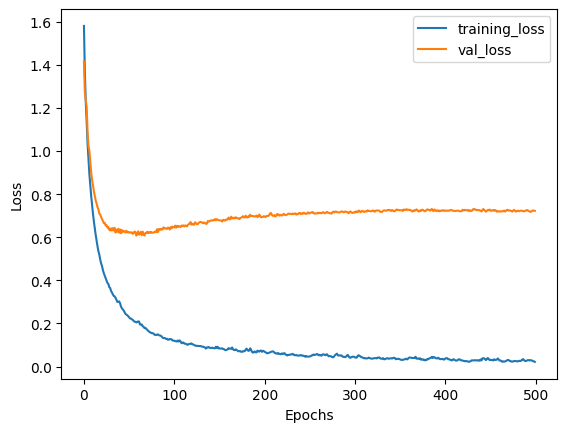

In [30]:
plt.plot(hist_ffnn_MBT.history['loss'], label='training_loss')
plt.plot(hist_ffnn_MBT.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [31]:
pred_train = ffnn_MBT.predict(X_train)
pred_test = ffnn_MBT.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


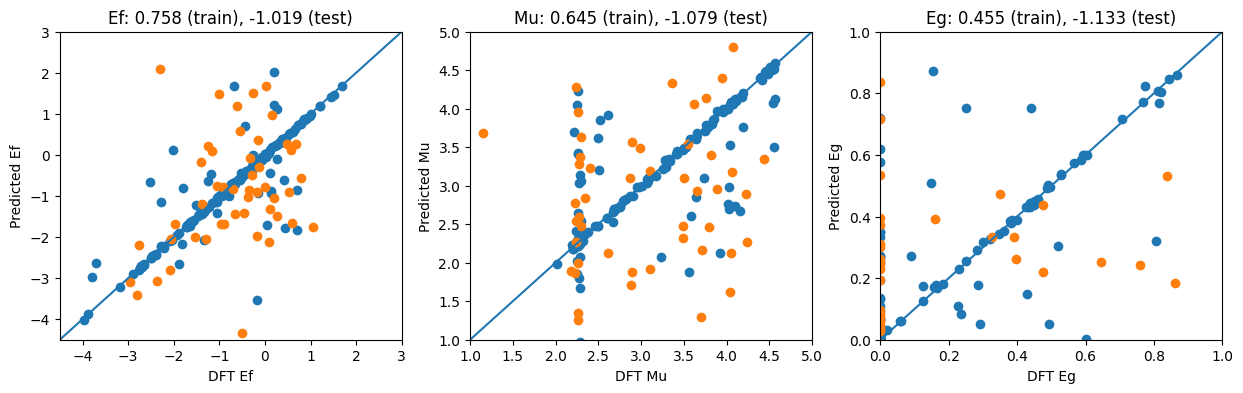

In [32]:
fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (15,4))
ax1.scatter(y_train['Ef_per_cell'], pred_train[:,0])
ax1.scatter(y_test['Ef_per_cell'], pred_test[:,0])
ax1.plot([-4.5, 3], [-4.5, 3])

ax2.scatter(y_train['Mu_per_cell'], pred_train[:,1])
ax2.scatter(y_test['Mu_per_cell'], pred_test[:,1])
ax2.plot([0, 5], [0, 5])

ax3.scatter(y_train['Eg'], pred_train[:,2])
ax3.scatter(y_test['Eg'], pred_test[:,2])
ax3.plot([0, 1], [0, 1])

ax1.set_title('Ef: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Ef_per_cell'], pred_train[:,0]),metrics.r2_score(y_test['Ef_per_cell'], pred_test[:,0])))
ax2.set_title('Mu: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Mu_per_cell'], pred_train[:,1]),metrics.r2_score(y_test['Mu_per_cell'], pred_test[:,1])))
ax3.set_title('Eg: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Eg'], pred_train[:,2]),metrics.r2_score(y_test['Eg'], pred_test[:,2])))

ax1.set_xlabel('DFT Ef')
ax1.set_ylabel('Predicted Ef')

ax2.set_xlabel('DFT Mu')
ax2.set_ylabel('Predicted Mu')

ax3.set_xlabel('DFT Eg')
ax3.set_ylabel('Predicted Eg')

ax1.set_xlim([-4.5, 3])
ax1.set_ylim([-4.5, 3])

ax2.set_xlim([1, 5])
ax2.set_ylim([1, 5])

ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])

plt.show()

In [33]:
print(metrics.r2_score(y_train['Ef_per_cell'], pred_train[:,0]))
print(metrics.r2_score(y_train['Mu_per_cell'], pred_train[:,1]))
print(metrics.r2_score(y_train['Eg'], pred_train[:,2]))

0.7582883447908485
0.6450289090925452
0.45469419502313657


In [34]:
print(metrics.mean_absolute_error(y_train['Ef_per_cell'], pred_train[:,0]))
print(metrics.mean_absolute_error(y_train['Mu_per_cell'], pred_train[:,1]))
print(metrics.mean_absolute_error(y_train['Eg'], pred_train[:,2]))

0.20713125020845957
0.20848750577867034
0.07386811951744991


In [35]:
print(metrics.r2_score(y_test['Ef_per_cell'], pred_test[:,0]))
print(metrics.r2_score(y_test['Mu_per_cell'], pred_test[:,1]))
print(metrics.r2_score(y_test['Eg'], pred_test[:,2]))

-1.0187244341627264
-1.0787373888716227
-1.1328653321406912


In [36]:
print(metrics.mean_absolute_error(y_test['Ef_per_cell'], pred_test[:,0]))
print(metrics.mean_absolute_error(y_test['Mu_per_cell'], pred_test[:,1]))
print(metrics.mean_absolute_error(y_test['Eg'], pred_test[:,2]))

1.0698024766574705
0.9273023484249912
0.26551707675550135
